In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import corenlp
import json
import pprint

In [158]:
df_dev = pd.read_csv("dev_v1.csv")
df_dev.head()
superboll_q =  df_dev.loc[df_dev['title']== 'Super_Bowl_50']
superboll_q.head()

,id,question,answer_0_text,answer_0_start,answer_1_text,answer_1_start,answer_2_text,answer_2_start,title,context,paragraph_idx
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249,Carolina Panthers,249.0,Carolina Panthers,249.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,"Santa Clara, California",403,Levi's Stadium,355.0,Levi's Stadium in the San Francisco Bay Area a...,355.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,gold,488,gold,488.0,gold,521.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0


In [3]:
corenlp_dir = "stanford-corenlp-full-2016-10-31/"
parser = corenlp.StanfordCoreNLP(corenlp_path=corenlp_dir)

In [159]:
result_json = json.loads(parser.parse("What is the AFC short for?"))
pprint.pprint(result_json)

{'sentences': [{'dependencies': [['root', 'ROOT', 'short'],
                                 ['nmod:for', 'short', 'What'],
                                 ['cop', 'short', 'is'],
                                 ['det', 'AFC', 'the'],
                                 ['nsubj', 'short', 'AFC'],
                                 ['case', 'What', 'for'],
                                 ['punct', 'short', '?']],
                'indexeddependencies': [['root', 'ROOT-0', 'short-5'],
                                        ['nmod:for', 'short-5', 'What-1'],
                                        ['cop', 'short-5', 'is-2'],
                                        ['det', 'AFC-4', 'the-3'],
                                        ['nsubj', 'short-5', 'AFC-4'],
                                        ['case', 'What-1', 'for-6'],
                                        ['punct', 'short-5', '?-7']],
                'parsetree': '[Text=is CharacterOffsetBegin=5 '
                             'C

## Extract keywords from sentence 
- Extract NNP with named entities 
- Extract nouns
- Extract vebs
(According to Moldovan's paper)
1. Select all nonUstop words in quotations
2. Select all NNP words in recognized named entities
3. Select all complex nominals with their adjectival modifiers
4. Select all other complex nominals
5. Select all nouns with their adjectival modifiers
6. Select all other nouns
7. Select all verbs
8. Select all adverbs
9. Select the QFW word(skipped in all previous steps)
10. Select all other words

In [160]:
# experimtn of collecting entities and postags from fucked up json(stile sentence)
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def find_pos_entity(sentence):
    result_json = json.loads(parser.parse(sentence))
    result_sentence = [text[1:] for text in result_json["sentences"][0]["parsetree"].split("] ")[:-1]]
    pos = {}
    entity = {}
    for j in range(len(result_sentence)):
        result_array = result_sentence[j].split(' ')

        for i in range(len(result_array)):
            text = result_array[0].split('=')[1]
            if text not in stop:
                tag = result_array[i].split('=')[0]
                if tag == 'PartOfSpeech' and result_array[i].split('=')[1] != '.':
                    pos[text] = result_array[i].split('=')[1]

                elif tag == 'NamedEntityTag' and result_array[i].split('=')[1] != 'O':
                    entity[text] = result_array[i].split('=')[1]
    return pos, entity

In [165]:
find_pos_entity("Who won in Super Bowl 50?")

{'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'50': 'NUMBER'}


({'50': 'CD', 'Bowl': 'NNP', 'Super': 'NNP'}, {'50': 'NUMBER'})

## Stanford CoreNLP references
- [Part of Sppech list](http://stackoverflow.com/questions/1833252/java-stanford-nlp-part-of-speech-labels)

## Question Processing
- Answer Type Detection
- Capture Named Entity
- Query Formulation 
- Choose Keywords
- Question Type Classification 
 - definition
 - math 
 - list
- Focus detection 
- Find the quesiton words that replace the answer

## Answer type detection
- ABBEVIATION 
- ENTITY 
 - CURRENCY
 - DISEASEMEDICINE
 - EVENT
 - FOOD
 - INSTRUMENT
 - LANGUAGE
- DESCRIPTION
 - DEFINITION
 - DESCRIPTION
 - MANNER
 - REASON
- HUMAN
- LOCATION
 - CITY
 - COUNTRY
 - MOUNTAIN
- NUMERIC
 - data 
 - distance 
 - size
 - money

In [6]:
print(len(df_dev.index))

10570


In [167]:
df_dev_10 = df_dev.sample(frac=0.1)
print(len(df_dev_10))
df_dev_10.to_csv("sample_questions.csv")

1057


In [168]:
df_qd = pd.read_csv("qd_ml_experiment.csv")
df_qd = df_qd.reindex(np.random.permutation(df_qd.index))
df_qd.head()

,Unnamed: 0,id,question,answer_0_text,LENGTH,TYPE,Unnamed: 6
200,NaN,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,52,HUMAN,NaN
70,8013.0,5728510f4b864d1900164937,The academic body of the university is made up...,four,81,NUMERIC,NaN
246,NaN,56d2045de7d4791d009025f5,How many times have the Panthers been in the S...,2,56,NUMERIC,NaN
126,8525.0,572924b53f37b31900478067,Who treats the majority of the population medi...,Nurses,52,HUMAN,NaN
167,1605.0,56e11ba9cd28a01900c675d8,How much did Tesla spend on the injured pigeon?,"over $2,000",47,NUMERIC,NaN


In [169]:
X = df_qd["question"].values
y = df_qd["TYPE"].values
X_train, X_test = X[:180], X[180:]
y_train, y_test = y[:180], y[180:]

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', norm="l2")
X_train_tfidf = vectorizer.fit_transform(X_train)
terms = vectorizer.get_feature_names()

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [187]:
sentence = "who founded Super bowl?"
s_tfidf = vectorizer.transform([sentence])

In [190]:
print(clf.predict(s_tfidf))

['ENTITY']


In [172]:
X_test_tfidf = vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
print(y_pred)

['ENTITY' 'ENTITY' 'HUMAN' 'ABBEVIATION' 'LOCATION' 'ENTITY' 'NUMERIC'
 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'NUMERIC'
 'DESCRIPTION' 'ENTITY' 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY' 'ENTITY'
 'HUMAN' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'LOCATION' 'LOCATION' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'LOCATION'
 'ENTITY' 'ENTITY' 'ENTITY' 'ABBEVIATION' 'ENTITY' 'ENTITY' 'NUMERIC'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY'
 'ENTITY']


In [173]:
from sklearn.metrics import accuracy_score
print('Accuracy : %.2f' % accuracy_score(y_test, y_pred))

Accuracy : 0.43


In [174]:
from sklearn import svm
svm = svm.SVC(C=1.5, kernel= 'linear')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print('Accuracy : %.2f' % accuracy_score(y_test, y_pred_svm))

Accuracy : 0.44


In [175]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

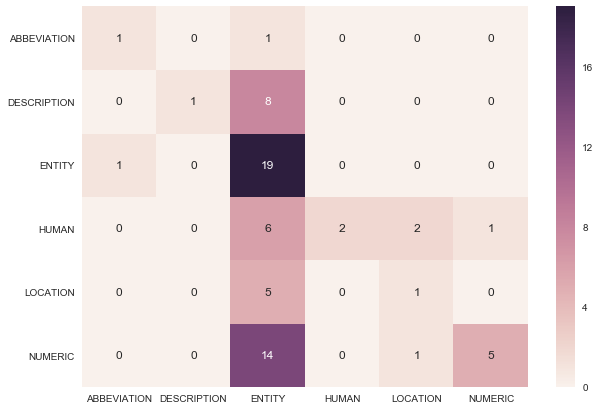

In [176]:
print_cmx(y_test,y_pred)

In [177]:
# Combination of RFC and rule-base
import nltk

def predict_answer_type(sentence):
    tokens = nltk.word_tokenize(sentence)
    
    if tokens[0] == 'Who':
        return 'HUMAN'
    elif tokens[0] == 'When':
        return 'NUMERIC'
    elif tokens[0] == 'Where':
        return 'LOCATION'
    
    first_two_tokens = ' '.join(tokens[:2])
    if first_two_tokens == 'How many' or first_two_tokens == "How much" or first_two_tokens == "What day" or first_two_tokens == "What year":
        return 'NUMERIC'
    
    
    return 'NONE'

In [178]:
print(y_pred)
y_pred_new = []
for i in range(len(X_test)):
    if predict_answer_type(X_test[i]) != 'NONE':
        y_pred_new.append(predict_answer_type(X_test[i]))
    else:
        y_pred_new.append(y_pred[i])

print(y_pred_new)

['ENTITY' 'ENTITY' 'HUMAN' 'ABBEVIATION' 'LOCATION' 'ENTITY' 'NUMERIC'
 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'NUMERIC'
 'DESCRIPTION' 'ENTITY' 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY' 'ENTITY'
 'HUMAN' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'LOCATION' 'LOCATION' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'LOCATION'
 'ENTITY' 'ENTITY' 'ENTITY' 'ABBEVIATION' 'ENTITY' 'ENTITY' 'NUMERIC'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY'
 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'ENTITY' 'NUMERIC' 'ENTITY' 'ENTITY'
 'ENTITY']
['NUMERIC', 'ENTITY', 'HUMAN', 'ABBEVIATION', 'HUMAN', 'ENTITY', 'NUMERIC', 'LOCATION', 'NUMERIC', 'ENTITY', 'ENTITY', 'ENTITY', 'ENTITY', 'NUMERIC', 'DESCRIPTION', 'ENTITY', 'ENTITY', 'HUMAN', 'ENTITY', 'ENTITY', 'ENTITY', 'HUMAN', 'ENTITY', 'ENTITY', 'ENTITY', 'ENTITY', 'ENTITY', 'NUMERIC', 'ENTITY', 'ENTITY', 'HUMAN', 'ENTITY', 'ENTITY', 'ENTITY

In [179]:
from sklearn.metrics import accuracy_score
print('Accuracy : %.2f' % accuracy_score(y_test, y_pred))

Accuracy : 0.43


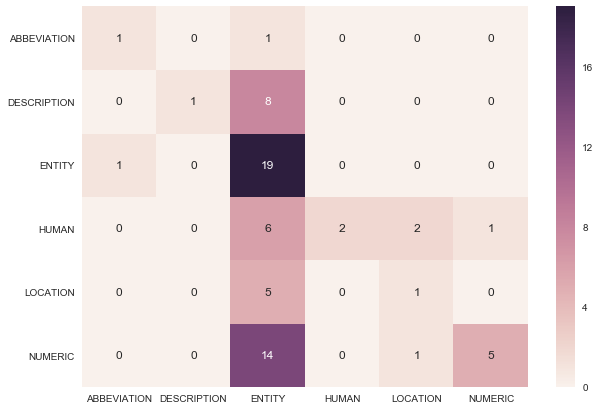

What 2015 NFL team one the AFC playoff?
ABBEVIATION ENTITY
For how many years was evidence shown that humans shaped the the Amazon?
ENTITY NUMERIC
What was the verdict on other alleged errors?
ENTITY DESCRIPTION
What is the height of the section that turns north?
ENTITY NUMERIC
What was the effect of the housing crash on the region?
ENTITY DESCRIPTION
"An Account of Further Discoveries in Air" was published by who in 1775?
ENTITY HUMAN
In what area is it common for spiritual mentorship to be extremely high?
ENTITY LOCATION
William would eventually gain what throne?
ENTITY LOCATION
What does the IPCC rely on for research?
ENTITY DESCRIPTION
In what town did Bill Aiken grow up?
ENTITY LOCATION
Who did Denver beat in the AFC championship?
HUMAN ENTITY
What country was Abhisit Vejjajiva prime minister of, despite having been born in Newcastle?
ENTITY HUMAN
Who did Carolina beat in the NFC championship game?
HUMAN ENTITY
What is different about Cyanidioschyzon merolæ?
ENTITY DESCRIPTION
The

In [180]:
print_cmx(y_test,y_pred)

for i in range(len(y_test)):
    if y_test[i] != y_pred_new[i]:
        print(X_test[i])
        print(y_pred_new[i], y_test[i])

In [181]:
y_pred_svm_new = []
for i in range(len(X_test)):
    if predict_answer_type(X_test[i]) != 'NONE':
        y_pred_svm_new.append(predict_answer_type(X_test[i]))
    else:
        y_pred_svm_new.append(y_pred[i])

In [182]:
from sklearn.metrics import accuracy_score
print('Accuracy : %.2f' % accuracy_score(y_test, y_pred_svm_new))

Accuracy : 0.66


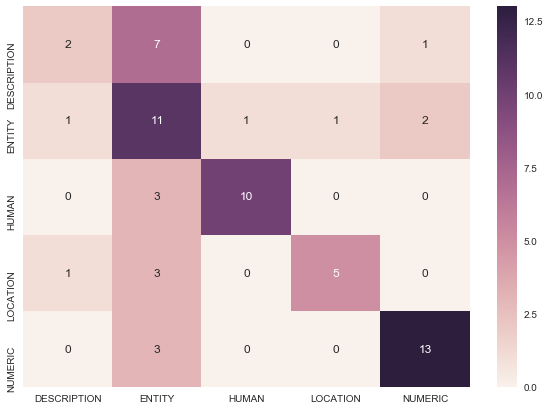

What does being an MSP share with the House of Commons?
ABBEVIATION DESCRIPTION
What may cause "motivational embellishment"?
ENTITY DESCRIPTION
What nationality is the band Coldplay?
ENTITY LOCATION
What put a hierarchical structure in place?
ENTITY DESCRIPTION
Which's of Genghis Khan's successors could not be successor because of his age?
ENTITY HUMAN
What other English towns were sites of Huguenot settlement?
ENTITY LOCATION
"An Account of Further Discoveries in Air" was published by who in 1775?
ENTITY HUMAN
What is the present-day location of this church?
NUMERIC ENTITY
What kind of cpDNA does maize have?
ABBEVIATION ENTITY
What did Thoreau claim about the majority?
DESCRIPTION ENTITY
What seldom mutates?
ENTITY DESCRIPTION
Are ctenophores predators, vegetarian or parasitic?
ENTITY DESCRIPTION
Who lost to the Broncos in the AFC Championship?
HUMAN ENTITY
Harrogate market is in the local what?
ENTITY DESCRIPTION
What is the height of the section that turns north?
ENTITY NUMERIC
What

In [23]:
print_cmx(y_test,y_pred_svm_new)

for i in range(len(y_test)):
    if y_test[i] != y_pred_new[i]:
        print(X_test[i])
        print(y_pred_new[i], y_test[i])
        

## Detect the answer types and keyword extraction
- accprding to the experimrnt result, the answer detenction and keyword extraction seems perfom well, so from now on, just creating the question dataset to predect the question.

In [24]:
df_keywords = pd.DataFrame(columns=['id','sentence', 'entities', 'NNPs', 'Nouns', 'Verbs', 'WP'])
print(df_keywords)

Empty DataFrame
Columns: [id, sentence, entities, NNPs, Nouns, Verbs, WP]
Index: []


VB Verb, base form
VBD Verb, past tense
VBG Verb, gerund or present participle
VBN Verb, past participle
VBP Verb, non­3rd person singular present
VBZ Verb, 3rd person singular present
WDT Wh­determiner

In [25]:
for i in range(len(X_test)):
    pos, entity = find_pos_entity(X_test[i])
    nnps = [k for (k, v) in pos.items() if v == 'NNP']
    nns = [k for (k, v) in pos.items() if v == 'NN']
    vbs = [k for (k, v) in pos.items() if 'VB' in v ]
    wp = X_test[i].split(' ')[0]
    df_keywords = df_keywords.append({'sentence':X_test[i], \
                                      'entities': entity, 'NNPs': nnps, 'Nouns':nns, 'Verbs': vbs,'WP':wp},ignore_index=True)
    

In [26]:
df_keywords.head()
# df_keywords.tail()
print(df_keywords['entities'].values)

[{}
 {'MSP': 'ORGANIZATION', 'House': 'ORGANIZATION', 'Commons': 'ORGANIZATION'}
 {}
 {'2015': 'DATE', 'Carolina': 'ORGANIZATION', 'Panthers': 'ORGANIZATION'}
 {} {'Coldplay': 'ORGANIZATION'} {'Panthers': 'ORGANIZATION'} {}
 {'year': 'DURATION', 'Saints': 'ORGANIZATION', '13-0': 'NUMBER'}
 {'Genghis': 'PERSON', 'Khan': 'PERSON'}
 {'Luther': 'PERSON', 'Germany': 'LOCATION'} {'English': 'MISC'}
 {'1775': 'DATE'} {} {}
 {'Huguenots': 'MISC', 'North': 'LOCATION', 'America': 'LOCATION'}
 {'first': 'ORDINAL', 'ABC': 'ORGANIZATION'} {'50': 'NUMBER'} {} {} {} {}
 {'50': 'NUMBER'} {'Rhine': 'LOCATION'} {} {'Thoreau': 'PERSON'} {} {}
 {'Jacksonville': 'LOCATION', 'currently': 'DATE', 'years': 'DURATION'} {}
 {'Britain': 'LOCATION'}
 {'Broncos': 'ORGANIZATION', 'AFC': 'MISC', 'Championship': 'MISC'} {}
 {'Denver': 'ORGANIZATION', 'Broncos': 'ORGANIZATION'} {} {}
 {'England': 'LOCATION', 'France': 'LOCATION'} {}
 {'month': 'DURATION', 'day': 'DURATION', 'year': 'DURATION', '50': 'NUMBER'}
 {'Samar

In [27]:
#looks like it's working now. Congrats on myself! 


## How can we do machine learning for question answering?
### Features
- Answer type match : contains the phrase with a correct answer type. 
- Pattern match : regular experession pattern match the candidate. 
- Question keywords : the number of question keyword. 
- Keyword Distance : distance with keywords. 
- Novelty Factor : A word in candidates is not in question query.
- Apposition features : 
- Punctuation location : followed by , "" . 
- Sequence of Question terms : The length of question seqeucen of question terms that occurs in candidate answer. 


## Idea - Try wasy features 
- Answer type match (Human == Human) (NUMBER == NUMERIC || 'DURATION' || 'DATE') (ENTITY == 'ORGANIZATION' || "MISC") ("LOCATION" == "LOCATION")
- Pattern match 
- Keyword Distance
- Entity distance 
- Puctuation Location 
- the number of NNP
- the numebr of NN
- the number of Entities
- Verb match 

- you can compare the word match also. 
```wordmathc.py
>>> [word for word in a_word if word in b_word]
```
- if you don't do regular expression, co-occurence of words can be helpful.
```experiment.py
>>> a = "My dog name is John.".replace(" ", "")
>>> b = "What is her dog name?".replace(" ", "")
>>> c = "I like playing the piano".replace(" ", "")
>>> len([e for e in b if e in c])
11
>>> len([e for e in b if e in a])
13
>>>
```


## Doing the first machine learning Question answering system!! 

In [28]:
df_dev = pd.read_csv("dev_v1.csv")
df_dev.head()

,id,question,answer_0_text,answer_0_start,answer_1_text,answer_1_start,answer_2_text,answer_2_start,title,context,paragraph_idx
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249,Carolina Panthers,249.0,Carolina Panthers,249.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,"Santa Clara, California",403,Levi's Stadium,355.0,Levi's Stadium in the San Francisco Bay Area a...,355.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,gold,488,gold,488.0,gold,521.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0


In [29]:
super_bowl = df_dev[:50]

In [30]:
super_bowl.tail()
q_tfidf = vectorizer.transform(super_bowl["question"].values)
answer_type = svm.predict(q_tfidf)
pred_new = []
questions = super_bowl["question"].values
for i in range(len(super_bowl)):
    if predict_answer_type(questions[i]) != 'NONE':
        pred_new.append(predict_answer_type(questions[i]))
    else:
        pred_new.append(y_pred[i])

print(pred_new)
# this is the answer type 

['DESCRIPTION', 'ABBEVIATION', 'LOCATION', 'NUMERIC', 'NUMERIC', 'ENTITY', 'NUMERIC', 'ENTITY', 'NUMERIC', 'ENTITY', 'NUMERIC', 'HUMAN', 'ENTITY', 'ENTITY', 'ENTITY', 'ENTITY', 'NUMERIC', 'LOCATION', 'NUMERIC', 'ENTITY', 'ENTITY', 'NUMERIC', 'LOCATION', 'ENTITY', 'HUMAN', 'DESCRIPTION', 'NUMERIC', 'LOCATION', 'NUMERIC', 'ENTITY', 'ENTITY', 'NUMERIC', 'NUMERIC', 'NUMERIC', 'HUMAN', 'HUMAN', 'HUMAN', 'HUMAN', 'NUMERIC', 'HUMAN', 'NUMERIC', 'ENTITY', 'ENTITY', 'NUMERIC', 'ABBEVIATION', 'HUMAN', 'HUMAN', 'NUMERIC', 'HUMAN', 'HUMAN']


In [236]:
df_keywords = pd.DataFrame(columns=['id','sentence', 'entities', 'NNPs', 'Nouns', 'Verbs', 'WP', 'AnswerType'])

for i in range(len(questions)):
    pos, entity = find_pos_entity(questions[i])
    nnps = [k for (k, v) in pos.items() if v == 'NNP']
    nns = [k for (k, v) in pos.items() if v == 'NN']
    vbs = [k for (k, v) in pos.items() if 'VB' in v ]
    wp = X_test[i].split(' ')[0]
    df_keywords = df_keywords.append({'sentence':questions[i], \
                                      'entities': entity, 'NNPs': nnps, 'Nouns':nns, \
                                      'Verbs': vbs,'WP':wp, \
                                     'AnswerType': pred_new[i]},ignore_index=True)
df_keywords.head()

{'NFL': 'NNP', 'team': 'NN', 'represented': 'VBD', 'AFC': 'NNP', 'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'NFL': 'ORGANIZATION', '50': 'NUMBER'}
{'NFL': 'NNP', 'team': 'NN', 'represented': 'VBD', 'NFC': 'NN', 'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'NFL': 'ORGANIZATION', 'NFC': 'ORGANIZATION', '50': 'NUMBER'}
{'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD', 'take': 'VB', 'place': 'NN'} {'50': 'NUMBER'}
{'NFL': 'NNP', 'team': 'NN', 'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'NFL': 'ORGANIZATION', '50': 'NUMBER'}
{'color': 'NN', 'used': 'VBN', 'emphasize': 'VB', '50th': 'JJ', 'anniversary': 'NN', 'Super': 'NNP', 'Bowl': 'NNP'} {'50th': 'ORDINAL'}
{'theme': 'NN', 'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'50': 'NUMBER'}
{'day': 'NN', 'game': 'NN', 'played': 'VBN'} {'day': 'DURATION'}
{'AFC': 'NNP', 'short': 'JJ'} {}
{'theme': 'NN', 'Super': 'NNP', 'Bowl': 'NNP', '50': 'CD'} {'50': 'NUMBER'}
{'AFC': 'NNP', 'stand': 'VB'} {}
{'day': 'NN', 'Super': 'NNP', 'Bowl': 'NNP', 'played': 'VBD'}

,id,sentence,entities,NNPs,Nouns,Verbs,WP,AnswerType
0,NaN,Which NFL team represented the AFC at Super Bo...,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","[NFL, AFC, Super, Bowl]",[team],[represented],How,DESCRIPTION
1,NaN,Which NFL team represented the NFC at Super Bo...,"{'NFL': 'ORGANIZATION', 'NFC': 'ORGANIZATION',...","[NFL, Super, Bowl]","[team, NFC]",[represented],Cells,ABBEVIATION
2,NaN,Where did Super Bowl 50 take place?,{'50': 'NUMBER'},"[Super, Bowl]",[place],[take],Which,LOCATION
3,NaN,Which NFL team won Super Bowl 50?,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","[NFL, Super, Bowl]",[team],[],What,NUMERIC
4,NaN,What color was used to emphasize the 50th anni...,{'50th': 'ORDINAL'},"[Super, Bowl]","[color, anniversary]","[used, emphasize]",Who,NUMERIC


In [237]:
question = df_keywords["sentence"][10]
NNPs = df_keywords["NNPs"][10]
entities = df_keywords["entities"][10].keys()


In [238]:
def splitParagraphIntoSentences(paragraph):
    ''' break a paragraph into sentences
        and return a list '''
    import re
    # to split by multile characters

    #   regular expressions are easiest (and fastest)
    sentenceEnders = re.compile('[.!?]')
    sentenceList = sentenceEnders.split(paragraph)
    return sentenceList

In [239]:
sentences = splitParagraphIntoSentences(df_dev["context"].values[0])
print(sentences)

['Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season', ' The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title', " The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California", ' As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50', '']


In [244]:
def entity_match(answer_type, candidate_type):
    if answer_type == "HUMAN":
        if "HUMAN" in candidate_type:
            return True
    elif answer_type == "LOCATION":
        if "LOCATION" in candidate_type:
            return True
    elif answer_type == "ENTITY":
        if "ENTITY" in candidate_type or "MISC" in candidate_type or 'ORGANIZATION' in candidate_type :
            return True
    elif answer_type == "NUMERIC":
        if "NUMBER" in candidate_type or "DURATION" in candidate_type or "DATE" in candidate_type:
            return True
    else:
        return False    
    
def isverbmatched(verbs, s_words):

    for verb in verbs:
        for token in s_words:
            if token.lower() == verb:
                return True
    return False
    
def find_word_index_in_sentence(word, sentence):
    token_sentence = sentence.split(' ')
    index = 0
    for token in token_sentence:
        if word.lower() == token.lower():
            return index
        index += 1
    return 100
    
def dis_from_keyword(grams, keywords, sentence):
    word_index = find_word_index_in_sentence(grams[0], sentence)
    keyword_indices = [find_word_index_in_sentence(keyword, sentence) for keyword in keywords]
    return min([abs(word_index - keyword_index) for keyword_index in keyword_indices])    

In [245]:
print(find_word_index_in_sentence("dog", "i like the dog"))

3


In [246]:
count = 0
from nltk import ngrams
df_x = pd.DataFrame(columns=["word","numofkeywords","numofnnps","numofnns","entitymatch","diskey","verbmatch", "punc"])

q_info = df_keywords.loc[10, :]
q_words = question.split(" ")
for sentence in sentences:
    if len(sentence) > 0:
        pos, entity = find_pos_entity(sentence)
        bigrams = ngrams(sentence.split(), 2)
        s_words = sentence.split(" ")
        if len([word for word in s_words if word in q_words]) > 2:
            count += 1
            for gram in bigrams:
                if gram[0] not in stop and gram[1] not in stop:
                    num_keywords = len([word for word in s_words if word in keywords])
                    num_nnps = len([word for word in s_words if word in q_info["NNPs"]])
#                     print(q_info["Nouns"])
                    num_nns = len([word for word in s_words if word in q_info["Nouns"]])
                    v_match = isverbmatched(q_info["Verbs"], s_words)
                    diskey = 200
#                     if num_keywords:
                    keywords = q_info["NNPs"]
                    entities = q_info["entities"].keys()
                    dis = min(dis_from_keyword(gram, keywords, sentence), dis_from_keyword(gram, entities, sentence))
                         
                    c_type = []
                    for word in gram:
                        if word in entity.keys():
                            c_type.append(entity[word])
                    e_match = True if entity_match(q_info["AnswerType"], c_type) else False

                    df_x = df_x.append({"word": gram[0] + ' ' + gram[1], "numofkeywords":num_keywords, \
                                 "numofnnps" : num_nnps, "numofnns": num_nns, "entitymatch":e_match, "diskey":dis,"verbmatch":v_match},ignore_index=True)

df_x.head()
df_x.to_csv("first_trial.csv")

{'Bowl': 'NNP', '50': 'CD', 'American': 'JJ', 'football': 'NN', 'game': 'NN', 'determine': 'VB', 'champion': 'NN', 'National': 'NNP', 'Football': 'NNP', 'League': 'NNP', '-LRB-': '-LRB-', 'NFL': 'NNP', '-RRB-': '-RRB-', '2015': 'CD', 'season': 'NN'} {'50': 'NUMBER', 'American': 'MISC', 'National': 'ORGANIZATION', 'Football': 'ORGANIZATION', 'League': 'ORGANIZATION', 'NFL': 'ORGANIZATION', '2015': 'DATE'}
{'American': 'JJ', 'Football': 'NNP', 'Conference': 'NNP', '-LRB-': '-LRB-', 'AFC': 'NN', '-RRB-': '-RRB-', 'champion': 'NN', 'Denver': 'NNP', 'Broncos': 'NNS', 'defeated': 'VBD', 'National': 'NNP', 'NFC': 'NNP', 'Carolina': 'NNP', 'Panthers': 'NNP', '24': 'CD', '--': ':', '10': 'CD', 'earn': 'VB', 'third': 'JJ', 'Super': 'NNP', 'Bowl': 'NNP', 'title': 'NN'} {'Denver': 'ORGANIZATION', 'Broncos': 'ORGANIZATION', 'National': 'ORGANIZATION', 'Football': 'ORGANIZATION', 'Conference': 'ORGANIZATION', 'NFC': 'ORGANIZATION', 'Carolina': 'ORGANIZATION', 'Panthers': 'ORGANIZATION', '24': 'NUMBE

In [247]:
df_x.head()

,word,numofkeywords,numofnnps,numofnns,entitymatch,diskey,verbmatch,punc
0,Super Bowl,2.0,2.0,0.0,False,0.0,False,NaN
1,Bowl 50,2.0,2.0,0.0,True,0.0,False,NaN
2,American football,2.0,2.0,0.0,False,4.0,False,NaN
3,football game,2.0,2.0,0.0,False,5.0,False,NaN
4,National Football,2.0,2.0,0.0,False,13.0,False,NaN


In [276]:
df_columns = ['id', 'question', 'answer_0_text', 'answer_0_start', 'answer_1_text', 'answer_1_start',
              'answer_2_text', 'answer_2_start', 'title', 'context', 'paragraph_idx',
              'AnswerType', 'entities', 'NNPs', 'NNs', 'VBs', 'WP']
df_e = pd.read_csv("df_dev_updated.csv")
# df_e = df_e.drop(df_e.columns["Unnamed: 0"], axis=1, inplace=True)
df_e = df_e[df_columns]
df_e.head()


,id,question,answer_0_text,answer_0_start,answer_1_text,answer_1_start,answer_2_text,answer_2_start,title,context,paragraph_idx,AnswerType,entities,NNPs,NNs,VBs,WP
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,HUMAN,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","['NFL', 'AFC', 'Super', 'Bowl']",['team'],['represented'],[]
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249,Carolina Panthers,249.0,Carolina Panthers,249.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,HUMAN,"{'NFL': 'ORGANIZATION', 'NFC': 'ORGANIZATION',...","['NFL', 'Super', 'Bowl']","['team', 'NFC']",['represented'],[]
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,"Santa Clara, California",403,Levi's Stadium,355.0,Levi's Stadium in the San Francisco Bay Area a...,355.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,LOCATION,{'50': 'NUMBER'},"['Super', 'Bowl']",['place'],['take'],[]
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,ENTITY,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","['NFL', 'Super', 'Bowl']",['team'],[],[]
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,gold,488,gold,488.0,gold,521.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,ENTITY,{'50th': 'ORDINAL'},"['Super', 'Bowl']","['color', 'anniversary']","['used', 'emphasize']",[]


In [292]:
def load_target_csv(id):
    from ast import literal_eval
    df_columns = ['id', 'question', 'answer_0_text', 'answer_0_start', 'answer_1_text', 'answer_1_start',
                  'answer_2_text', 'answer_2_start', 'title', 'context', 'paragraph_idx',
                  'AnswerType', 'entities', 'NNPs', 'NNs', 'VBs', 'WP']
    df = pd.read_csv("df_dev_updated.csv", index_col=0)
    df = df[df_columns]
#     print(df)
    questions = df.loc[df['id'] == id].iloc[0]
#     print(questions.iloc[0])
#     print(questions["context"])
    print(type(questions["NNs"]))
    print(type(literal_eval(questions["NNs"])))
    print(type(literal_eval(questions["entities"])))
#     print(questions["answer_0_text"])
    return questions
load_target_csv("5725e08389a1e219009ac012")

<class 'str'>
<class 'list'>
<class 'dict'>


id                                         5725e08389a1e219009ac012
question                      When was Apollo 6, or AS-502, tested?
answer_0_text                                         April 4, 1968
answer_0_start                                                  450
answer_1_text                                                  1968
answer_1_start                                                  459
answer_2_text                                         April 4, 1968
answer_2_start                                                  450
title                                                Apollo_program
context           The delay in the CSM caused by the fire enable...
paragraph_idx                                                    40
AnswerType                                                  NUMERIC
entities                                            {'6': 'NUMBER'}
NNPs                                                     ['Apollo']
NNs                                             

In [201]:
df_keywords = pd.read_csv("keywords.csv")
df_keywords.head()

,Unnamed: 0,entities,NNPs,Nouns,Verbs,WP,NNs,VBs
0,0,"{'Bolivians': 'MISC', 'Newcastle': 'LOCATION'}",['Newcastle'],NaN,NaN,[],['number'],"[""'s"", 'estimated']"
1,1,"{'Bill': 'PERSON', 'Aiken': 'PERSON'}","['Bill', 'Aiken']",NaN,NaN,[],['mother'],['adopted']
2,2,"{'Mathematician': 'MISC', 'Harvard': 'ORGANIZA...","['Fields', 'Harvard']",NaN,NaN,[],"['Medal', 'Mathematician', 'faculty', 'member']",['winning']
3,3,{'Rankine': 'PERSON'},['Rankine'],NaN,NaN,[],"['heat', 'rejection', 'cycle']",['occur']
4,4,{},[],NaN,NaN,[],"['type', 'presence']",[]


In [220]:
# df_dev_10["entities"] = df_keywords["entities"]
print(len(df_e))
print(len(df_keywords))
for i in range(len(df_e)):
    df_e = df_e.set_value(i,'entities',df_keywords.loc[i,"entities"],)
    df_e = df_e.set_value(i,'NNs',df_keywords.loc[i,"NNs"],)
df_e.head()

106
106


,Unnamed: 0,id,question,answer_0_text,answer_0_start,answer_1_text,answer_1_start,answer_2_text,answer_2_start,title,context,paragraph_idx,AnswerType,entities,NNs
0,3994,5725e08389a1e219009ac012,"When was Apollo 6, or AS-502, tested?","April 4, 1968",450,1968,459.0,"April 4, 1968",450.0,Apollo_program,The delay in the CSM caused by the fire enable...,40,NUMERIC,"{'Bolivians': 'MISC', 'Newcastle': 'LOCATION'}",['number']
1,4699,5725d662ec44d21400f3d68a,Which is one of the park features located in N...,Shinzen Japanese Gardens,135,Shinzen Japanese Gardens,135.0,NaN,NaN,"Fresno,_California","Fresno has three large public parks, two in th...",5,NUMERIC,"{'Bill': 'PERSON', 'Aiken': 'PERSON'}",['mother']
2,9167,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,86 km,172,86 km,172.0,86 km long,172.0,Rhine,Near Tamins-Reichenau the Anterior Rhine and t...,3,NUMERIC,"{'Mathematician': 'MISC', 'Harvard': 'ORGANIZA...","['Medal', 'Mathematician', 'faculty', 'member']"
3,8964,5729784b1d046914007794ca,What are FtsZ1 and FtsZ2?,proteins,37,proteins,37.0,proteins,37.0,Chloroplast,The division process starts when the proteins ...,59,ENTITY,{'Rankine': 'PERSON'},"['heat', 'rejection', 'cycle']"
4,7231,5727e0474b864d1900163f0b,What famous civil rights leader called Harvard...,W. E. B. Du Bois,27,W. E. B. Du Bois,27.0,W. E. B. Du Bois,27.0,Harvard_University,Other: Civil rights leader W. E. B. Du Bois; p...,28,HUMAN,{},"['type', 'presence']"


In [211]:
answer_df= pd.read_csv("answer.csv")
print(answer_df["entities"])

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
5                                                     NaN
6                                                     NaN
7                                                     NaN
8                                                     NaN
9                                                     NaN
10                                                    NaN
11                                                    NaN
12                                                    NaN
13                                                    NaN
14                                                    NaN
15                                                    NaN
16                                                    NaN
17            

In [294]:
df1 = pd.read_csv("df_feature_experiment.csv")
df1.head()

,word,question_id,question,num_of_keywords,num_of_eneities,num_of_nnps,num_of_nns,entity_matched,min_distance_key,verb_matched,Y,verbmatch
0,Near Tamins-Reichenau,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,0.0,0.0,0.0,0.0,False,30.0,NaN,False,0.0
1,Anterior Rhine,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,0.0,0.0,0.0,0.0,False,30.0,NaN,False,0.0
2,Posterior Rhine,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,0.0,0.0,0.0,0.0,False,30.0,NaN,False,0.0
3,Rhine join,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,0.0,0.0,0.0,0.0,False,30.0,NaN,False,0.0
4,The river,572fe41e04bcaa1900d76e4c,How long is the section that turns north?,0.0,0.0,0.0,1.0,False,30.0,NaN,False,0.0


In [135]:
df_0001 = pd.read_csv("0.001sampling.csv")
df_0001.tail()
print(len(df_0001))

353


In [14]:
df_final = pd.read_csv("01sampling_Word.csv")
df_final.head()
df_final["verb_matched"].values
df_final.loc[df_final["verb_matched"] == True, "verb_matched"] = 1
df_final.loc[df_final["verb_matched"] == False, "verb_matched"] = 0
df_final.tail()

,answer_entity_type,answers,capital,constituency_tag,entity_matched,min_distance_key,num_of_eneities,num_of_keywords,num_of_nnps,num_of_nns,pos,punctuation,question,question_id,shared_word_num,text_similarity,token,token_entity_type,verb_matched,word
99650,ENTITY,"['The original logo', 'The original logo used ...",False,NaN,False,30.0,0.0,0.0,0.0,3.0,VBG,False,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,0.183063,NaN,None,False,relating
99651,ENTITY,"['The original logo', 'The original logo used ...",False,NaN,False,30.0,0.0,0.0,0.0,3.0,TO,False,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,0.183063,NaN,None,False,to
99652,ENTITY,"['The original logo', 'The original logo used ...",False,NaN,False,30.0,0.0,0.0,0.0,3.0,DT,False,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,0.183063,NaN,None,False,the
99653,ENTITY,"['The original logo', 'The original logo used ...",False,NaN,False,30.0,0.0,0.0,0.0,3.0,JJ,False,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,0.183063,NaN,DATE,False,current
99654,ENTITY,"['The original logo', 'The original logo used ...",False,NaN,False,30.0,0.0,0.0,0.0,3.0,SS,False,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,0.183063,NaN,None,False,Doctor


In [15]:
# creaning up the dataframe
df_final.dtypes

answer_entity_type     object
answers                object
capital                  bool
constituency_tag      float64
entity_matched           bool
min_distance_key      float64
num_of_eneities       float64
num_of_keywords       float64
num_of_nnps           float64
num_of_nns            float64
pos                    object
punctuation              bool
question               object
question_id            object
shared_word_num       float64
text_similarity       float64
token                 float64
token_entity_type      object
verb_matched             bool
word                   object
dtype: object

In [16]:
def swap_bool_value_to_int(column_name, df):
    new_column_name = column_name + '_bool'
    df.loc[df[column_name] == True, new_column_name] = 1
    df.loc[df[column_name] == False, new_column_name] = 0

for column in ["entity_matched", "verb_matched", "capital", "punctuation"]:
    swap_bool_value_to_int(column, df_final)


def creat_new_column_for_postage(df, pos_index):
    pos_column_name = "pos"
        
    for word in set(df[pos_column_name].values):
        new_column_name = pos_column_name + '_' + word
        df.loc[df[pos_column_name] == word, new_column_name] = 1
        df.loc[df[pos_column_name] != word,new_column_name] = 0


creat_new_column_for_postage(df_final, 1)
creat_new_column_for_postage(df_final, 0)
df_final.drop(["entity_matched", "constituency_tag","verb_matched", "capital", "punctuation","pos"],inplace=True,axis=1)
df_final.tail()
df_final.dtypes
df_final.to_csv("01sampling_Word_cleaned.csv")

NameError: name 'df_final' is not defined

In [17]:
df_final.head()

,answer_entity_type,answers,min_distance_key,num_of_eneities,num_of_keywords,num_of_nnps,num_of_nns,question,question_id,shared_word_num,...,pos_VBN,pos_VBD,pos_EX,pos_WP$,"pos_,",pos_NNP,pos_JJS,pos_'',pos_PRP,pos_VBZ
0,ENTITY,"['establish, equip, manage and maintain nation...",30.0,0.0,0.0,0.0,0.0,What is the KNLS responsible for?,572927d06aef051400154adf,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENTITY,"['establish, equip, manage and maintain nation...",30.0,0.0,0.0,0.0,0.0,What is the KNLS responsible for?,572927d06aef051400154adf,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENTITY,"['establish, equip, manage and maintain nation...",30.0,0.0,0.0,0.0,0.0,What is the KNLS responsible for?,572927d06aef051400154adf,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENTITY,"['establish, equip, manage and maintain nation...",30.0,0.0,0.0,0.0,0.0,What is the KNLS responsible for?,572927d06aef051400154adf,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENTITY,"['establish, equip, manage and maintain nation...",30.0,0.0,0.0,0.0,0.0,What is the KNLS responsible for?,572927d06aef051400154adf,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
def create_Y_label(df):
    for i in range(len(df.index)):
        if df.loc[i, "word"] in df.loc[i, "answers"]:
            df.loc[i, "Y"] = "True"
        else:
            df.loc[i, "Y"] = "False"
create_Y_label(df_final)

    
                

In [140]:
df_final.tail()
df_final["Y"].value_counts()
df_final.to_csv("01sampling_cleaned.csv")

In [141]:
df_Y = pd.read_csv("01sampling_cleaned.csv")
df_Y.drop('constituency_tag', axis=1, inplace=True)
df_Y.head()

,Unnamed: 0,word,question_id,question,answers,shared_word_num,num_of_keywords,num_of_eneities,num_of_nnps,num_of_nns,...,pos2_IN,pos2_CC,pos2_RBR,pos2_DT,pos2_VBG,pos2_WRB,pos2_:,pos2_UH,pos2_VBD,Y
0,0,drainage basin,5729e6313f37b319004785aa,Near where in the continent is it believed tha...,"['Purus Arch', 'along the middle', 'Purus Arch']",13.0,2.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,1,split along,5729e6313f37b319004785aa,Near where in the continent is it believed tha...,"['Purus Arch', 'along the middle', 'Purus Arch']",13.0,2.0,1.0,1.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,2,Purus Arch,5729e6313f37b319004785aa,Near where in the continent is it believed tha...,"['Purus Arch', 'along the middle', 'Purus Arch']",13.0,2.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,3,eastern side,5729e6313f37b319004785aa,Near where in the continent is it believed tha...,"['Purus Arch', 'along the middle', 'Purus Arch']",5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,4,side flowed,5729e6313f37b319004785aa,Near where in the continent is it believed tha...,"['Purus Arch', 'along the middle', 'Purus Arch']",5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [142]:
print(df_Y.index)


RangeIndex(start=0, stop=29890, step=1)


In [143]:
X = df_Y.loc[:,"shared_word_num":"pos2_UH"]
Y = df_Y.loc[:, "Y"]

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [145]:
X = StandardScaler().fit_transform(X)

X_train, X_test = X[:20000],X[20000:]

y_train, y_test = Y[:20000],Y[20000:]

lr= LogisticRegression(class_weight="balanced", n_jobs=-1, C=0.5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [146]:
y_pred_proba = lr.predict_proba(X_test)
print(lr.classes_)
print(y_pred_proba)

[False  True]
[[ 0.64785617  0.35214383]
 [ 0.23758467  0.76241533]
 [ 0.20666235  0.79333765]
 ..., 
 [ 0.67006287  0.32993713]
 [ 0.87588994  0.12411006]
 [ 0.69689664  0.30310336]]


In [147]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(y_pred[-3])

df_Y["proba"] = 0
df_Y["proba_false"] = 0 

0.703741152679
             precision    recall  f1-score   support

      False       0.98      0.70      0.82      9478
       True       0.09      0.71      0.17       412

avg / total       0.95      0.70      0.79      9890

False


In [155]:
for i in range(len(y_pred_proba)):
#     if y_pred_proba[i][0] < y_pred_proba[i][1] and  y_pred_proba[i][1]> 0.7:
    df_Y.loc[20000 + i, "proba"] = y_pred_proba[i][1]
    df_Y.loc[20000 + i, "proba_false"] = y_pred_proba[i][0]
#         print("The question: " + df_Y.loc[20000 + i, "question"])
#         print("The answer: " + df_Y.loc[20000 + i, "answers"])
#         print("The predicted answer: " + df_Y.loc[20000 + i, "word"] + "   " +  str(y_pred_proba[i][1]))
df_Y.tail()

,Unnamed: 0,word,question_id,question,answers,shared_word_num,num_of_keywords,num_of_eneities,num_of_nnps,num_of_nns,...,pos2_RBR,pos2_DT,pos2_VBG,pos2_WRB,pos2_:,pos2_UH,pos2_VBD,Y,proba,proba_false
29885,29885,schools students,572746addd62a815002e9a5f,"Along with sport and art, what is a type of ta...","['academic', 'academic', 'academic']",4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.556364,0.443636
29886,29886,students may,572746addd62a815002e9a5f,"Along with sport and art, what is a type of ta...","['academic', 'academic', 'academic']",4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.329478,0.670522
29887,29887,"cost cheaper,",572746addd62a815002e9a5f,"Along with sport and art, what is a type of ta...","['academic', 'academic', 'academic']",4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.329937,0.670063
29888,29888,"cheaper, depending",572746addd62a815002e9a5f,"Along with sport and art, what is a type of ta...","['academic', 'academic', 'academic']",4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,0.124110,0.875890
29889,29889,student may,572746addd62a815002e9a5f,"Along with sport and art, what is a type of ta...","['academic', 'academic', 'academic']",4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.303103,0.696897


In [1]:
for c, coef in zip(list(df_Y)[5:-1], lr.coef_[0]):
    print(c, coef)

NameError: name 'df_Y' is not defined

In [150]:
len(df_Y[20000:].question_id.unique())

338

In [159]:
#df['first_name'].notnull() & (df['nationality'] == "USA")]
answer_df = pd.DataFrame()
for id in df_Y[20000:].question_id.unique():
    partial_df = df_Y.loc[df_Y["question_id"] == id]
    partial_df = partial_df.sort_values(by=['proba'], ascending=[False])
    answer_df = pd.concat([answer_df, partial_df[:5]])

answer_df.to_csv("answers.csv")   

In [160]:
df= pd.read_csv("train_v1.csv")
print(len(df.index))

87599


# Summary of benchmark experiment

## Process Questions
- Answer Type Detection
- Capture Named Entity
- Choose Keywords
- Question Type Classification


### Answer type detection
#### 分類
- ABBEVIATION
- ENTITY
- DESCRIPTION
- NUMERIC
- HUMAN
- LOCATION

#### 行なったこと
- dev.jsonデータから300個のデータについてラベルづけ -> SVMにより他クラス分類 : Accuracy 43%
- ルールベースで"WHO" -> "HUMAN"など明示的なものを修正 : Accuracy 72%
- StanfordCoreNLPにより、namedEntityを抽出。
- keyword抽出のルールから、{NNP, NN}などをキーワードとして抽出。[keywordselectionalgorithm](https://web.eecs.umich.edu/~mihalcea/papers/moldovan.trec99.pdf)

```rule.py
def predict_answer_type(sentence):
    tokens = nltk.word_tokenize(sentence)
    
    if tokens[0] == 'Who':
        return 'HUMAN'
    elif tokens[0] == 'When':
        return 'NUMERIC'
    elif tokens[0] == 'Where':
        return 'LOCATION'
    
    first_two_tokens = ' '.join(tokens[:2])
    if first_two_tokens == 'How many' or first_two_tokens == "How much" or first_two_tokens == "What day" or first_two_tokens == "What year":
        return 'NUMERIC'
    
    
    return 'NONE'
```


### Passage Retrieval and AnswerExtraction
- Passageは質問に対応したParagraph
- Passageの全ての文のうち、全く質問文と共通する語を持たない文を除外した上で、残った文章について、bigramで回答候補を作成
- (Unigram, Trigramも試したかったが計算量的に…)
- Featureについては以下の3項目を中心に作成
1. Entity macth
2. Shared keywords 
    - The # of named entities 
    - The # of NNPs
    - The # of NNs
    - Verb match
3. The min distance of keywords
4. POS tag
5. Semantic/Syntactic similarities
    - Constinuency tags 
    - Cos similarities of text (tf-idf based)
    - Minimum Edit Distance (not yet)
6. Punctuation([, ] , (, ), ", ")
7. Capital letter

In [163]:
df_Y = pd.read_csv("01sampling_cleaned.csv")
df_Y.drop('constituency_tag', axis=1, inplace=True)
df_Y.head()
list(df_Y)

['Unnamed: 0',
 'word',
 'question_id',
 'question',
 'answers',
 'shared_word_num',
 'num_of_keywords',
 'num_of_eneities',
 'num_of_nnps',
 'num_of_nns',
 'min_distance_key',
 'text_similarity',
 'entity_matched_bool',
 'verb_matched_bool',
 'capital_bool',
 'punctuation_bool',
 'pos1_NN',
 'pos1_JJ',
 'pos1_WP$',
 'pos1_VBP',
 'pos1_NNS',
 'pos1_WDT',
 'pos1_LS',
 'pos1_MD',
 'pos1_RB',
 'pos1_JJR',
 'pos1_VB',
 'pos1_RP',
 'pos1_VBZ',
 'pos1_SS',
 'pos1_JJS',
 'pos1_FW',
 'pos1_CD',
 'pos1_VBN',
 'pos1_NNP',
 'pos1_PRP',
 'pos1_,',
 'pos1_IN',
 'pos1_CC',
 'pos1_RBR',
 'pos1_DT',
 'pos1_VBG',
 'pos1_WRB',
 'pos1_:',
 'pos1_VBD',
 'pos2_NN',
 'pos2_JJ',
 'pos2_WP$',
 'pos2_VBP',
 'pos2_NNPS',
 'pos2_NNS',
 'pos2_SYM',
 'pos2_LS',
 'pos2_MD',
 'pos2_RB',
 'pos2_JJR',
 'pos2_VB',
 'pos2_RP',
 'pos2_VBZ',
 'pos2_SS',
 'pos2_JJS',
 'pos2_FW',
 'pos2_CD',
 'pos2_VBN',
 'pos2_NNP',
 'pos2_PRP',
 'pos2_IN',
 'pos2_CC',
 'pos2_RBR',
 'pos2_DT',
 'pos2_VBG',
 'pos2_WRB',
 'pos2_:',
 'pos2_UH

### Result 
- paragraphに含まれるbigram(Stopwordsを除く)ごとに質問に対する特徴量を作成
- Yラベルを”答えになる・ならない”で予測
accuracy:
0.703741152679
             precision    recall  f1-score   support

      False       0.98      0.70      0.82      9478
       True       0.09      0.71      0.17       412

avg / total       0.95      0.70      0.79      9890

- Precisionが低く、Recallが高い→ 上位5位までの答えを実際の回答候補として選択
- [expected answers](https://docs.google.com/spreadsheets/d/1ijFQGk60dF6eKRf77beKYQVxUeSqlO1L7CxEG9I7kt8/edit#gid=1971328036)
- WHO, LOCATION, DATAについては7割前後（bigramで答えを限定しているため、厳密な精度計算まだ）
- 重要な特徴量
   - text_similarity(cos_similarity) 0.83406571197
       Semantic Similarity(Character-based sentence similarity)やSyntactic Similarity(Dependency TreeやMinimum Edit Distanceなど)
   - entity_matched_bool 0.0707064268099 
   -> Ansertypeの予測自体の精度が低い　×　StanfordNamedEntityも常に確実な答えを返すわけではない
   - verb_matched_bool 0.109449853071
   - POSTagもTagによっては良い特徴となる -> Dependency Tag, Constituency Tag についてより詳細に
   - pos2_RB 0.175154854914
   - pos2_JJR 0.101650438109
   - pos2_VB 0.127060234318

### 課題
- 答えはどう精製されるべき？
- Answertypeはどう検知されるべきか？機械学習-> Rule Baseではおそらく80%が限界なのでは。
- Description typeの質問など、文章からの単語の抽出だけでは不十分 -> LSTM? (そもそもの質問によって答えの生成の仕方を帰るべき？)
- データの前処理で1000件の質問に対し1時間ほど。（作成される答えは30k）StanfordCoreNLP等がネックだがPandasでのデータ操作もforループなど回避しても時間がかかる。Training8万件の質問……
- 深層学習モデル + Semantic Syntactic Similarityを合わせてモデルを作っていく？
- StanfordCoreNLP以外の（高速かつPythonから問題なく呼べる）ライブラリはあるのか(CoreNLPはそもそも返してくる値がおかしい)

In [101]:
import pandas as pd
import ast

df_ver2 = pd.read_csv("01sampling_Word_cleaned.csv")
print(df_ver2.question_id)

0        572927d06aef051400154adf
1        572927d06aef051400154adf
2        572927d06aef051400154adf
3        572927d06aef051400154adf
4        572927d06aef051400154adf
5        572927d06aef051400154adf
6        572927d06aef051400154adf
7        572927d06aef051400154adf
8        572927d06aef051400154adf
9        572927d06aef051400154adf
10       572927d06aef051400154adf
11       572927d06aef051400154adf
12       572927d06aef051400154adf
13       572927d06aef051400154adf
14       572927d06aef051400154adf
15       572927d06aef051400154adf
16       572927d06aef051400154adf
17       572927d06aef051400154adf
18       572927d06aef051400154adf
19       572927d06aef051400154adf
20       572927d06aef051400154adf
21       572927d06aef051400154adf
22       572927d06aef051400154adf
23       572927d06aef051400154adf
24       572927d06aef051400154adf
25       572927d06aef051400154adf
26       572927d06aef051400154adf
27       572927d06aef051400154adf
28       572927d06aef051400154adf
29       57292

In [100]:
temp_df = df_ver2.loc[df_ver2["question_id"] == "57281f203acd2414000df4f5"]
temp_df.head()
list(temp_df)

['Unnamed: 0',
 'answer_entity_type',
 'answers',
 'min_distance_key',
 'num_of_eneities',
 'num_of_keywords',
 'num_of_nnps',
 'num_of_nns',
 'question',
 'question_id',
 'shared_word_num',
 'text_similarity',
 'token',
 'token_entity_type',
 'word',
 'entity_matched_bool',
 'verb_matched_bool',
 'capital_bool',
 'punctuation_bool',
 'pos_WRB',
 'pos_VB',
 'pos_$',
 'pos_``',
 'pos_JJR',
 'pos_RBS',
 'pos_WP',
 'pos_SS',
 'pos_TO',
 'pos_VBG',
 'pos_POS',
 'pos_RBR',
 'pos_CD',
 'pos_:',
 'pos_FW',
 'pos_NNS',
 'pos_SYM',
 'pos_VBP',
 'pos_RB',
 'pos_RP',
 'pos_JJ',
 'pos_NNPS',
 'pos_NN',
 'pos_PRP$',
 'pos_CC',
 'pos_DT',
 'pos_IN',
 'pos_WDT',
 'pos_PDT',
 'pos_LS',
 'pos_MD',
 'pos_VBN',
 'pos_VBD',
 'pos_EX',
 'pos_WP$',
 'pos_,',
 'pos_NNP',
 'pos_JJS',
 "pos_''",
 'pos_PRP',
 'pos_VBZ',
 'category',
 'token_entity_type_TIME',
 'token_entity_type_MISC',
 'token_entity_type_LOCATION',
 'token_entity_type_PERSON',
 'token_entity_type_PERCENT',
 'token_entity_type_NUMBER',
 'token_

In [86]:
# YOU SUCK.
def flatten(nested_list):
    """2重のリストをフラットにする関数"""
    return [e for inner_list in nested_list for e in inner_list]

def create_class_label(df, original_df):
    answered = 0
    answers = df["answers"].iloc[0]
    
    if ", nan" in answers:
        answers = answers[:-6] + ']'
    if ", nan" in answers:
        answers = answers[:-6] + ']'
    answers = ast.literal_eval(answers)
    
    answer_word_list = flatten([[word for word in answer.split(' ')] for answer in answers])
    for i in df.index:
        if df.loc[i, "word"] in [answer.split(' ')[0] for answer in answers]:
            original_df.loc[i, "category"] = "B"
            answered = 1
        elif df.loc[i, "word"] in [answer.split(' ')[-1] for answer in answers] and answered:
            original_df.loc[i, "category"] = "E"
        elif df.loc[i, "word"] in answer_word_list and answered :
            original_df.loc[i, "category"] = "M"
        else:
            original_df.loc[i, "category"] = "O"
    

In [97]:
temp_df = df_ver2.loc[df_ver2["question_id"] == "57281f203acd2414000df4f5"]
temp_df.head()
create_class_label(temp_df, df_ver2)

NameError: name 'create_class_label' is not defined

In [88]:
for question_id in set(df_ver2["question_id"]):
    temp_df = df_ver2.loc[df_ver2["question_id"] == question_id]
    create_class_label(temp_df, df_ver2)

In [94]:
print(df_ver2.category.value_counts())

O    93368
M     2829
B     2433
E     1025
Name: category, dtype: int64


In [95]:
# Function for creating new columns for qualitive data.

def creat_new_column_for_entity(df, is_token=True):
    if is_token:
        entity_column_name= "token_entity_type"
    else:
        entity_column_name= "answer_entity_type"
        
    for word in set(df[entity_column_name].values):
        new_column_name = entity_column_name + '_' + word
        df.loc[df[entity_column_name] == word, new_column_name] = 1
        df.loc[df[entity_column_name] != word,new_column_name] = 0
        
def swap_bool_value_to_int(column_name, df):
    new_column_name = column_name + '_bool'
    df.loc[df[column_name] == True, new_column_name] = 1
    df.loc[df[column_name] == False, new_column_name] = 0

def creat_new_column_for_postage(df, pos_index):
    pos_column_name = "pos"
        
    for word in set(df[pos_column_name].values):
        new_column_name = pos_column_name + '_' + word
        df.loc[df[pos_column_name] == word, new_column_name] = 1
        df.loc[df[pos_column_name] != word,new_column_name] = 0

In [101]:
creat_new_column_for_entity(df_ver2, is_token=True)
creat_new_column_for_entity(df_ver2, is_token=False)

In [103]:
df_ver2.dtypes
list(df_ver2)

['Unnamed: 0',
 'answer_entity_type',
 'answers',
 'min_distance_key',
 'num_of_eneities',
 'num_of_keywords',
 'num_of_nnps',
 'num_of_nns',
 'question',
 'question_id',
 'shared_word_num',
 'text_similarity',
 'token',
 'token_entity_type',
 'word',
 'entity_matched_bool',
 'verb_matched_bool',
 'capital_bool',
 'punctuation_bool',
 'pos_WRB',
 'pos_VB',
 'pos_$',
 'pos_``',
 'pos_JJR',
 'pos_RBS',
 'pos_WP',
 'pos_SS',
 'pos_TO',
 'pos_VBG',
 'pos_POS',
 'pos_RBR',
 'pos_CD',
 'pos_:',
 'pos_FW',
 'pos_NNS',
 'pos_SYM',
 'pos_VBP',
 'pos_RB',
 'pos_RP',
 'pos_JJ',
 'pos_NNPS',
 'pos_NN',
 'pos_PRP$',
 'pos_CC',
 'pos_DT',
 'pos_IN',
 'pos_WDT',
 'pos_PDT',
 'pos_LS',
 'pos_MD',
 'pos_VBN',
 'pos_VBD',
 'pos_EX',
 'pos_WP$',
 'pos_,',
 'pos_NNP',
 'pos_JJS',
 "pos_''",
 'pos_PRP',
 'pos_VBZ',
 'category',
 'token_entity_type_TIME',
 'token_entity_type_MISC',
 'token_entity_type_LOCATION',
 'token_entity_type_PERSON',
 'token_entity_type_PERCENT',
 'token_entity_type_NUMBER',
 'token_

In [112]:
df_ver2.drop(["token"],inplace=True,axis=1)

In [133]:
df_ver2.fillna(value=0, inplace=True)
df_ver2["text_similarity"]

0        0.282197
1        0.282197
2        0.282197
3        0.282197
4        0.282197
5        0.282197
6        0.282197
7        0.282197
8        0.282197
9        0.282197
10       0.282197
11       0.282197
12       0.282197
13       0.282197
14       0.282197
15       0.282197
16       0.282197
17       0.282197
18       0.282197
19       0.282197
20       0.282197
21       0.282197
22       0.282197
23       0.282197
24       0.282197
25       0.323444
26       0.323444
27       0.323444
28       0.323444
29       0.323444
           ...   
99625    0.183063
99626    0.183063
99627    0.183063
99628    0.183063
99629    0.183063
99630    0.183063
99631    0.183063
99632    0.183063
99633    0.183063
99634    0.183063
99635    0.183063
99636    0.183063
99637    0.183063
99638    0.183063
99639    0.183063
99640    0.183063
99641    0.183063
99642    0.183063
99643    0.183063
99644    0.183063
99645    0.183063
99646    0.183063
99647    0.183063
99648    0.183063
99649    0

In [134]:
df_ver2.dtypes
df_ver2.to_csv("input_data.csv")
df_ver2.tail()

,Unnamed: 0,answers,min_distance_key,num_of_eneities,num_of_keywords,num_of_nnps,num_of_nns,question,question_id,shared_word_num,...,token_entity_type_DURATION,token_entity_type_ORDINAL,token_entity_type_None,token_entity_type_DATE,answer_entity_type_ENTITY,answer_entity_type_LOCATION,answer_entity_type_ABBEVIATION,answer_entity_type_NUMERIC,answer_entity_type_HUMAN,answer_entity_type_DESCRIPTION
99650,99650,"['The original logo', 'The original logo used ...",30.0,0.0,0.0,0.0,3.0,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99651,99651,"['The original logo', 'The original logo used ...",30.0,0.0,0.0,0.0,3.0,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99652,99652,"['The original logo', 'The original logo used ...",30.0,0.0,0.0,0.0,3.0,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99653,99653,"['The original logo', 'The original logo used ...",30.0,0.0,0.0,0.0,3.0,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
99654,99654,"['The original logo', 'The original logo used ...",30.0,0.0,0.0,0.0,3.0,What logo was modified and reused for the 50th...,57281f203acd2414000df4f5,13.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Expect "Begin of Answer" "End of Answer" "Mid of ANswer"

In [261]:
import pandas as pd

df_ver2 = pd.read_csv("final_input_fix_category.csv")

In [262]:
set(df_ver2)
set(['answers','question','question_id','token','word'])
columns = list(set(df_ver2) - set(['answers','question','question_id','token','word','category','Unnamed: 0','Unnamed: 0.1',"answer_entity_type","token_entity_type"]))
index_columns = ['answers','question','question_id','word']
print(columns)
# print(df_ver2.iloc[0])

['num_of_nns', 'pos_TO', 'punctuation_bool', 'pos_LS', 'num_of_keywords', 'pos_SYM', 'pos_DT', 'num_of_eneities', 'entity_matched_bool', 'pos_,', 'pos_VBD', 'pos_PRP', 'pos_NN', 'pos_SS', 'pos_WRB', 'pos_WP', 'pos_WDT', 'pos_PDT', "pos_''", 'pos_JJS', 'min_distance_key', 'pos_VBG', 'pos_NNPS', 'pos_EX', 'capital_bool', 'pos_MD', 'pos_JJR', 'pos_NNP', 'pos_VBZ', 'pos_NNS', 'pos_VB', 'pos_JJ', 'pos_RBR', 'pos_:', 'pos_VBP', 'pos_CD', 'pos_FW', 'pos_RP', 'pos_WP$', 'pos_RB', 'pos_``', 'num_of_nnps', 'shared_word_num', 'pos_POS', 'pos_$', 'pos_RBS', 'pos_CC', 'pos_PRP$', 'verb_matched_bool', 'text_similarity', 'pos_IN', 'pos_VBN']


In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [264]:
import numpy as np
X = df_ver2[columns]
table = df_ver2[index_columns]
y = df_ver2["category"]
df_ver2.dtypes
X = X.replace(np.nan, '0')
X.isnull().sum()

num_of_nns             0
pos_TO                 0
punctuation_bool       0
pos_LS                 0
num_of_keywords        0
pos_SYM                0
pos_DT                 0
num_of_eneities        0
entity_matched_bool    0
pos_,                  0
pos_VBD                0
pos_PRP                0
pos_NN                 0
pos_SS                 0
pos_WRB                0
pos_WP                 0
pos_WDT                0
pos_PDT                0
pos_''                 0
pos_JJS                0
min_distance_key       0
pos_VBG                0
pos_NNPS               0
pos_EX                 0
capital_bool           0
pos_MD                 0
pos_JJR                0
pos_NNP                0
pos_VBZ                0
pos_NNS                0
pos_VB                 0
pos_JJ                 0
pos_RBR                0
pos_:                  0
pos_VBP                0
pos_CD                 0
pos_FW                 0
pos_RP                 0
pos_WP$                0
pos_RB                 0


In [265]:
X = StandardScaler().fit_transform(X)

X_train, X_test = X[:70000],X[70000:]

y_train, y_test = y[:70000],y[70000:]

lr= LogisticRegression(class_weight="balanced", n_jobs=-1, C=0.8)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)

In [266]:
def return_class_label(y_pred, lr):
    y_pred_label = []
    classes = lr.classes_
    for i in range(len(y_pred)):
        y_pred_label.append(classes[np.argmax(y_pred[i])])
    return y_pred_label

In [267]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


y_pred_label = np.asarray(return_class_label(y_pred,lr))
print(precision_score(y_test, y_pred_label, average='macro'))
print(recall_score(y_test, y_pred_label, average='macro'))

0.309469070905
0.3193144297


In [268]:
df_result = pd.DataFrame()

for word0, proba0, category0,answer0 in zip(table.word[7000:], y_pred,y_pred_label, table.answers[7000:]):
    df2 = pd.DataFrame([[word0,proba0, answer0, category0]], columns=["word","proba","answer","category"])
    df_result = df_result.append(df2, ignore_index=True)

In [269]:
df_result.to_csv("result_word.csv")

In [270]:
dic = {}
for c, coef in zip(columns, lr.coef_[0]):
    dic[c] =coef

from operator import itemgetter
sorted(dic.items(), key=itemgetter(1))

[('pos_WDT', -0.56336449344232065),
 ('pos_:', -0.36977700702964778),
 ('pos_CC', -0.33300487172943322),
 ('pos_,', -0.32286701470280033),
 ('pos_WP', -0.31374882712395685),
 ('pos_WRB', -0.27482437476539379),
 ('pos_RP', -0.26956446527761996),
 ('pos_VBD', -0.22849945109541381),
 ('pos_RBR', -0.2277137080465016),
 ('pos_RBS', -0.20637520747858495),
 ('pos_IN', -0.18269568367051428),
 ('pos_RB', -0.17499360295902056),
 ('shared_word_num', -0.16995439994861994),
 ('num_of_nnps', -0.14918368113863079),
 ('pos_FW', -0.13395650410363638),
 ('pos_$', -0.10306812402502674),
 ('pos_PDT', -0.10297168978259778),
 ('pos_VBZ', -0.094448190297650253),
 ('pos_WP$', -0.090925309761279369),
 ('pos_SYM', -0.089929892866907543),
 ('pos_VBP', -0.089393802131623082),
 ('pos_TO', -0.086837589978981583),
 ('pos_PRP', -0.084318242063231366),
 ('capital_bool', -0.071200569012905224),
 ('pos_LS', -0.069000582468776994),
 ('punctuation_bool', -0.067293884746224733),
 ('num_of_keywords', -0.054802123388238554),

In [294]:
# remove stop words ver
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
print(len(df_ver2.index))
print(stop)
df_ver2 = df_ver2[~df_ver2["word"].isin(stop)]

print(df_ver2.word)
print(len(df_ver2.index))

# for index in df_ver2.index:
# #     if df_ver2.loc[i, "word"] in stop:
#     print(df_ver2.loc[index, "word"])

99655
{'few', 'i', 'about', 'both', 'how', 'can', 'before', 'to', 'which', 'a', 'further', 'so', 'herself', 'until', 'having', 'some', 'wouldn', 'he', 'd', 'over', 'myself', 'yourself', 'do', 'too', 't', 'same', 'during', 'o', 've', 'but', 'theirs', 'there', 'you', 'aren', 'why', 'they', 'such', 'ourselves', 'shouldn', 'be', 'than', 'couldn', 'if', 'itself', 'the', 'those', 'all', 'not', 'were', 'whom', 'is', 'does', 'them', 'should', 'hers', 'did', 'an', 'themselves', 'at', 'for', 'where', 'up', 'their', 'that', 'of', 'doesn', 'have', 'don', 'ma', 'was', 'wasn', 'your', 'haven', 'didn', 'shan', 'against', 'off', 'are', 'yourselves', 'we', 'she', 'above', 'had', 'as', 'down', 'on', 'will', 's', 'out', 'hadn', 'more', 'between', 'it', 'any', 'from', 'm', 'me', 'll', 'again', 'who', 'only', 'being', 'our', 'what', 'nor', 'now', 'y', 'into', 'won', 'his', 'am', 'him', 'own', 'my', 'ours', 'through', 'doing', 'isn', 'himself', 'while', 'been', 'these', 'has', 'hasn', 'in', 'very', 'mightn'

In [292]:
X = StandardScaler().fit_transform(X)

X_train, X_test = X[:70000],X[70000:]

y_train, y_test = y[:70000],y[70000:]

lr= LogisticRegression(class_weight="balanced", n_jobs=-1, C=0.8)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)

In [278]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


y_pred_label = np.asarray(return_class_label(y_pred,lr))
print(precision_score(y_test, y_pred_label, average='macro'))
print(recall_score(y_test, y_pred_label, average='macro'))

0.309469070905
0.3193144297


In [ ]:
from nltk import ngrams
from nltk import word_tokenize

sentence = 'this is a foo bar sentences and i want to ngramize it'
n = 6
sixgrams = ngrams(sentence.split(), n)
for grams in sixgrams:
  print(grams)

word_tokenize("Stephan Hawking,")

In [90]:
# Correct Function for sentence. 
def calculate_words_cooccurence(answer, gram):
    total_length = len(answer.split(' '))
    co_occur = 0
    for token in answer.split(' '):
        if token in gram:
            co_occur += 1

    return co_occur/total_length
        
def add_answer_label(answer, words):
    import operator
    
    grams = ngrams(words, len(answer.split(' ')))
    score_dic = {}
    index = 0

    for gram in grams:
        score_dic[index] = calculate_words_cooccurence(answer, gram)
        index += 1
    answer_gram_index = max(score_dic, key=score_dic.get)
    
    labels = []
    for i in range(len(words)):
        if i == answer_gram_index:
            labels.append("B")
            
            if len(answer) > 2:
                for j in range(len(answer.split(' ')) - 2):
                    labels.append("M")
    
            labels.append("E")
        else:
            labels.append("O")
    return labels
                

In [96]:
sentence = "Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the golden anniversary with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as Super Bowl L, so that the logo could prominently feature the Arabic numerals 50."
words = word_tokenize(sentence)
answer= "Denver Broncos"
print(add_answer_label(answer, words))

for word, label in zip(words, add_answer_label(answer, words)):
    if label is not "O":
        print(label, word)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'E', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
B Denver
E Broncos


In [114]:
def create_class_label_fixed(df, original_df):
    answered = 0
    answers = df["answers"].iloc[0]
    
    if ", nan" in answers:
        answers = answers[:-6] + ']'
    if ", nan" in answers:
        answers = answers[:-6] + ']'
    answers = ast.literal_eval(answers)
    
    answer_labels = add_answer_label(answers[0], list(df.word))
    
    index = 0
    for i in df.index:
        original_df.loc[i, "category"] = answer_labels[index]
        index += 1

In [115]:
temp_df = df_ver2.loc[df_ver2["question_id"] == "57281f203acd2414000df4f5"]
create_class_label_fixed(temp_df, df_ver2)
temp_df_updated = df_ver2.loc[df_ver2["question_id"] == "57281f203acd2414000df4f5"]
for word0, category0, answer0 in zip(temp_df_updated.word, temp_df_updated.category,temp_df_updated.answers):
    if category0 != 'O':
        print(word0, category0, answer0)

The B ['The original logo', 'The original logo used for the First Doctor', 'The original logo']
original M ['The original logo', 'The original logo used for the First Doctor', 'The original logo']
logo E ['The original logo', 'The original logo used for the First Doctor', 'The original logo']


In [116]:
for question_id in set(df_ver2["question_id"]):
    temp_df = df_ver2.loc[df_ver2["question_id"] == question_id]
    create_class_label_fixed(temp_df, df_ver2)
df_ver2.to_csv("final_input_fix_category.csv")

O    96502
M     1247
B      956
E      950
Name: category, dtype: int64

In [297]:
df_ver3 = pd.read_csv("01sampling_Word_0530.csv")
df_ver3.head()

,answer_entity_type,answers,capital,constituency_tag,entity_matched,min_distance_key,num_of_eneities,num_of_keywords,num_of_nnps,num_of_nns,pos,punctuation,question,question_id,shared_word_num,text_similarity,token,token_entity_type,verb_matched,word
0,ENTITY,['regain authority over his own people. They h...,False,NaN,False,21.0,1.0,2.0,1.0,0.0,SS,False,Why was Tanaghrisson supporting British efforts?,5733f309d058e614000b664a,2.0,0.162774,NaN,None,False,They
1,ENTITY,['regain authority over his own people. They h...,False,NaN,False,20.0,1.0,2.0,1.0,0.0,VBD,False,Why was Tanaghrisson supporting British efforts?,5733f309d058e614000b664a,2.0,0.162774,NaN,None,False,killed
2,ENTITY,['regain authority over his own people. They h...,False,NaN,False,19.0,1.0,2.0,1.0,0.0,JJ,False,Why was Tanaghrisson supporting British efforts?,5733f309d058e614000b664a,2.0,0.162774,NaN,None,False,many
3,ENTITY,['regain authority over his own people. They h...,False,NaN,True,0.0,1.0,2.0,1.0,0.0,SS,False,Why was Tanaghrisson supporting British efforts?,5733f309d058e614000b664a,2.0,0.162774,NaN,MISC,False,Canadians
4,ENTITY,['regain authority over his own people. They h...,False,NaN,False,0.0,1.0,2.0,1.0,0.0,",",True,Why was Tanaghrisson supporting British efforts?,5733f309d058e614000b664a,2.0,0.162774,NaN,None,False,","
